In [2]:
%config Completer.use_jedi = False

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Boosting & Stacking

Boostring(부스팅)은 약한 learner(학습기)를 여러 개 연결하여 강한 학습기를 만드는 ensemble 기법이다. Boosting의 main idea는 **<font color=red>앞의 모델을 보완</font>**해나가면서 일련의 learn(학습기)를 학습시키는 것이다. 어떤 방법으로 보완을 할까?

Boosting의 종류
- **AdaBoost(에이다 부스트, Adaptive Boostring)**
- **Gradient Boostring(그레디언트 부스팅)**
- XGBoost
- CatBoost

---
*(Advanced)*

### Classifer를 입력으로 받고, 결정경계를 그려주는 Help 함수

In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

---

## 1. AdaBoost
이전 학습기(learner)를 보완하는 새로운 학습기를 만드는 방법으로, <font color=red>이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는</font> 방법을 선택하는 분류기이다. 이렇게 하면 새로운 학습기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.

에이다 부스트 분류기를 만들려면 
   - 기반이 되는 첫 번째 분류기(예를 들어 결정 트리)를 훈련 세트에서 훈련시키고 예측을 만든다.
   - 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다.
   - 두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만든다.

### 데이터셋 로딩 / 학습, 테스트 셋 구분

In [5]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### 학습

Sklearn에서는 `AdaBoostClassifier`를 제공한다. 

에이다 부스트에서 사용하는 약한 학습기는 깊이가 1인 의사결정 그루터기(stump)를 사용한다.

In [7]:
from sklearn.tree import DecisionTreeClassifier
stump = DecisionTreeClassifier(max_depth=1)

In [8]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    base_estimator=stump, 
    n_estimators=200,
    algorithm="SAMME", 
    learning_rate=0.5, 
    random_state=42
)

In [9]:
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

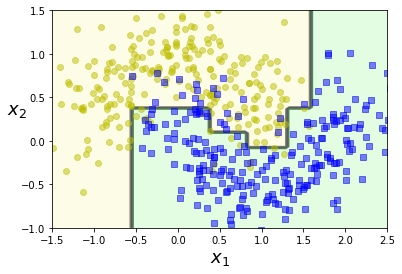

In [10]:
# 결정 경계를 plotting 한다.
plot_decision_boundary(ada_clf, X, y)

### Adaboost  algorithm

1. 각 샘플 가중치 $w^{(i)}$는 초기에 $\frac{1}{m}$로 초기화
2. 가중치가 적용된 에러율 $r_j$가 훈련 세트에 대해 계산됨. 
    - $r_{j} = \frac{\hat{y}_{j}^{(i)}\neq y^{(i)}}{\sum_{i=1}^{m}w^{(i)}}\text{(error rate)}  \text{ where } \hat{y}_{j}^{(i)} \text{  is a prediction of i-th sample from j-th base learner}$
3. 에러율을 기반으로 예측기의 가중치 $\alpha_j$이 계산됨.
    - $\alpha_j=\eta \log{({\frac{1-r_j}{r_j}})}$
4. 예측기의 가중치를 기반으로 샘플의 가중치를 업데이트. 즉, 잘못 분류된 샘플의 가중치가 증가
    - $w^{(i)} = w^{(i)} \text{ where } \hat{y}_j^{(i)}=y^{(i)}$
    - $w^{(i)} = w^{(i)} \exp{(\alpha_j)} \text{ where } \hat{y}_j^{(i)} \neq y^{(i)}$
5. 모든 샘플의 가중치를 정규화 ($\sum_{i=1}^{m}w^{(i)}$로 나누어줌)
6. 새 예측기가 업데이트된 가중치를 사용해 훈련되고, 2~5의 과정이 다시 반복한다.

### Prediction using Adaboost algorithm

에이다 부스트는 모든 예측기의 예측을 계산하고, 예측기 가중치 $\alpha_j$를 더해 예측 결과를 만든다. 가중치 합이 가장 큰 클래스가 예측 결과가 된다.

- $\hat{y}_j(x)$ : 샘플 $x$를 $j$번째 예측기를 이용하여 예측한 클래스 결과

- $\alpha_j$ : $j$번째 예측기의 가중치

$$\hat{y}(x)=\arg \max_k \sum_{j=1, \hat{y}_j(x)=k}^{N}\alpha_j$$

### SKlearn에서 사용하는 Adaboost algorithm : SAMME, SAMME.R

* 다중 클래스(Multi class) 분류기의 경우, Sklearn에서는 SAMME를 사용한다. $K$는 클래스의 수이며 예측기의 가중치를 구하는 식은 아래와 같다.
$$Base Model :\alpha_j=\eta (\log{(\frac{1-r_j}{r_j})}+\log(K-1))$$
* 예측기가 클래스의 확률을 추정하는 경우는 SAMME.R를 사용한다.
$$\alpha_j=\eta{\frac{K-1}{K}}y\log{\hat{y}_j}$$ 여기에서 $y$는 정답 클래스일때는 1, 아닐때는 $-\frac{1}{1-K}$이고, $\hat{y}_j$는 j번째 예측기가 만든 클래스 확률이다. 예측기별 클래스 확률을 계산해서 합한 후 확률이 가장 높은 클래스를 선택하며 관련 공식은 다음과 같다. $$\hat{y}(x)=\arg \max_k \sum_{j=1}^{N}(K-1)(\log{\hat{y}_j-\frac{1}{K}\sum_{k=0}^{K}\hat{y}_j})$$


SAMME.R(가중치를 조금 바꿔주는 것)을 사용하는 경우는 다음과 같다.

In [11]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=200,
    algorithm="SAMME.R", 
    learning_rate=0.5, 
    random_state=42
)

In [13]:
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

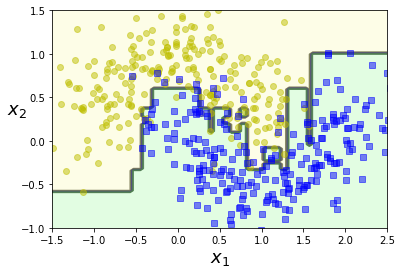

In [14]:
plot_decision_boundary(ada_clf, X, y)

## 2. Gradient boosting
Gradient boosting은 Adaboost와 동일하게 <U>앙상블 기법</U>과, <U>이전까지의 오차를 보정하도록 예측기를 순차적으로 추가하는 기법</U>을 사용한다. 하지만 Adaboost와는 달리 반복마다 샘플의 가중치를 수정하는 대신, 이전 **<font color=red>예측기가 만든 잔여 오차(residual error)에 새로운 예측기를 학습</font>** 한다.

### 데이터셋 생성

In [15]:
# Noise가 섞인 임의의 데이터 셋을 생성하여 테스트
np.random.seed(42)

# Uniform distribution을 따르는 데이터
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0]**2 + 0.05 * np.random.randn(100)

In [16]:
X[:10]

array([[-0.12545988],
       [ 0.45071431],
       [ 0.23199394],
       [ 0.09865848],
       [-0.34398136],
       [-0.34400548],
       [-0.44191639],
       [ 0.36617615],
       [ 0.10111501],
       [ 0.20807258]])

In [17]:
y[:10]

array([ 0.0515729 ,  0.59447979,  0.16605161, -0.07017796,  0.34398593,
        0.37287494,  0.65976498,  0.3763414 , -0.00975194,  0.10479474])

### Gradient Boosted Regression Tree (GBRT)

> Case 1 : Decision tree 3개를 이용하여, GBRT를 직접 구현

In [23]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

이전 예측기가 만든 **잔여 오차**를 구하자.

In [19]:
# 이전 예측기가 만든 잔여 오차가 y2
y2 = y - tree_reg1.predict(X)

In [20]:
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)

<font color=red>두 번째 학습기에서는 기존의 학습셋인 $y$가 아닌 잔여오차 $y2$를 이용하여 학습한다.</font>

In [18]:
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

세 번째 학습기에서는 두 번째 학습기에서 발생한 잔여 오차에 학습한다.

In [19]:
y3 = y2 - tree_reg2.predict(X)

In [20]:
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [21]:
# 테스트를 위해 값을 생성 (2번째 케이스에서 생성하는 모델과 비교해보자.)
X_new = np.array([[0.8]])

GBRT의 예측값은 **각 예측기 결과의 총합**이다.

In [22]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [23]:
y_pred

array([0.75026781])

---
(Advnaced)

NotFittedError: This DecisionTreeRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

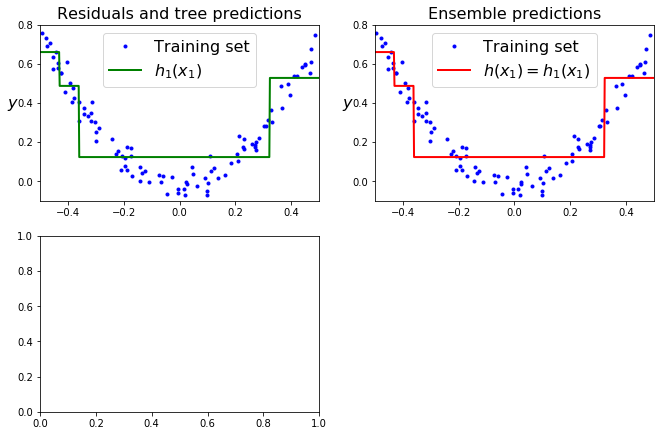

In [41]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

---

> Case 2 : Sklearn의 `GradientBoostingRegressor`를 직접사용
 - 첫 번째 GBRT는 base learner가 3개, learning rate가 1.0 이다.
 - 두 번째 GBRT는 base learner가 200개, learning rate가 0.1 이다.

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=3, 
    learning_rate=1.0, 
    random_state=42
)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [26]:
gbrt_slow = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=200, 
    learning_rate=0.1, 
    random_state=42
)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

Case 1에서의 예측 결과와 비교해보자. 동일하게 나온다.

In [27]:
# 학습기의 수가 3개이며 Case 1에서 생성한 모델과 동일한 모델의 결과
gbrt.predict(X_new)

array([0.75026781])

In [28]:
# 학습기의 수가 200개인 모델
gbrt_slow.predict(X_new)

array([0.74398943])

결과를 시각화 해보자.  
트리의 갯수가 오버피팅에 영향을 준다. Gridsearch등을 이용해 parameter를 찾아줘야한다.

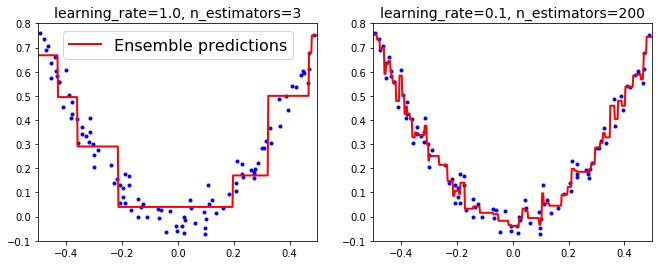

In [29]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}" \
          .format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}" \
          .format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

왼쪽 그림의 경우, 훈련 세트를 학습하기에는 트리가 충분하지 않아서 underfitting이 발생한 반면 오른쪽 그림의 경우, 트리가 너무 많아서 overfitting이 발생했다.

### 최적의 트리 수를 찾기 위한 방법 : 조기 종료 기법 1

 - `staged_predict()`: 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환한다. 즉 모든 base learner 및 그의 앙상블을 훈련시킨후, 그 앙상블을 순회하면서 검증값을 구함

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

In [25]:
# 예측기 120개를 사용한다. 다 순회하면서 최적의 모델을 찾는다. (1):1, 2):1+2, 3):1+2+3...additive)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=120, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

120개의 예측기를 모두 순회하며, mse를 구한다. 따라서 에러를 담은 리스트의 크기는 120이 될 것이다.

In [35]:
from sklearn.metrics import mean_squared_error
#mse 제일 작은놈 찾기
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

In [36]:
print('예측기들의 에러 크기 :', len(errors))
errors[:5]

예측기들의 에러 크기 : 120


[0.03976434066090687,
 0.03301153878946109,
 0.027663386192027795,
 0.023337263188229852,
 0.020390590545872743]

그 중에서 mse의 크기가 가장 작은 예측기를 선택한다.

In [37]:
bst_n_estimators = np.argmin(errors)
bst_n_estimators

55

가장 작은 mse를 가지는 예측기의 개수를 underfitting과 overfitting 사이를 적절하게 균형잡게 하는 예측기의 개수로 이용하자.

In [38]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=bst_n_estimators, 
    random_state=42
)

In [39]:
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

예측기의 갯수에 따른 mse의 변화를 시각화해보자.

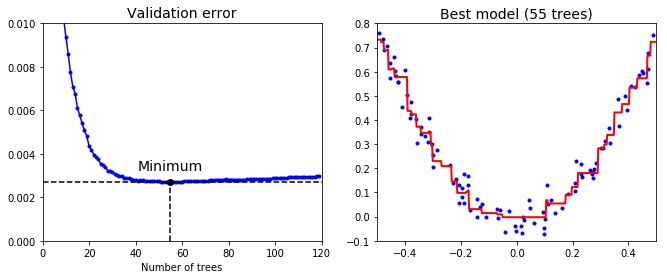

In [42]:
min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

### 최적의 트리 수를 찾기 위한 방법 : 조기 종료 기법 2
- 검증 오차가 더 이상 향상되지 않으면 훈련을 멈춘다.

In [43]:
gbrt = GradientBoostingRegressor(
    max_depth=2, 
    warm_start=True, 
    random_state=42
)

In [44]:
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    # 학습기의 개수를 1~120으로 변화시켜가며 테스트한다.
    gbrt.n_estimators = n_estimators
    # 학습한다.
    gbrt.fit(X_train, y_train)
    # 예측값을 구한다.
    y_pred = gbrt.predict(X_val)
    # MSE
    val_error = mean_squared_error(y_val, y_pred)
    # 지금까지 발생했던 가장 작은 에러보다, 더 작은 에러가 발생하면,
    # 가장 작은 에러에 현재 발생한 에러를 대입한다.
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    # 지금까지 발생했던 에러보다, 현재 발생하는 에러가 큰 경우가 6번 연속인 경우,
    # 학습을 끝낸다.
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # Early stopping

In [45]:
print(gbrt.n_estimators)

61


In [46]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


Sklearn에서 제공하는 `GradientBoostringRegressor`는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있다. 

이 경우, 각 base learner는 random하게 선택된 훈련 샘플로 학습된다. 따라서 편향이 높아지는 대신, 분산이 낮아지게 된다.

## 3. XgBoost

`xgboost`를 설치한다.

In [53]:
import xgboost

In [54]:
xgboost.__version__

'0.80'

Xgboost를 학습하는 것은 다음과 같다.

In [46]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)

print("Validation MSE:", val_error)

Validation MSE: 0.0028512559726563943


Xgboost를 학습하면서, 학습 도중 과대/과소 적합을 검증 할 수 있고, 성능을 측정할 수 있다.

학습시에, `eval_set`을 사용하면 된다.

eval_set 주면 디버깅이 됨

In [47]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)

y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)

print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse:0.051821
[26]	validation_0-rmse:0.051226
[27]	validation_0-rmse:0.051135
[28]	validation_0-rmse:0.05091
[29]	validation_0-rmse

XGboost 괜찮은 feature를 보고 알아서 선정함, corr을 줄일 수 있음

Gradient boosted regression tree의 MSE와 비교했을 때 성능이 더 좋다.

또한 xgboost는 시스템 최적화를 목표로 하였기 때문에, 속도가 빠르다.

In [51]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train)

6.19 ms ± 669 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

19.1 ms ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 4. Stacking

**Stacked generalization(Stacking)** : Ensemble에 속한 모든 예측기의 예측을 취합하는 간단한 함수(예를 들어, 투표 or 평균)를 사용하는 대신, 예측기의 모든 결과를 취합하는 새로운 학습 모델을 추가적으로 만드는 것이다. 각각의 예측기의 결과를 마지막 meta learner 또는 blender가 입력으로 받아 최종 예측을 출력한다.

Meta learner or Blender를 학습시키는 일반적인 방법은 hold out 세트를 이용하는 것이다.
 - 먼저 훈련 세트를 두 개의 subset으로 나눈다.
     - 첫 번째 subset은 첫 번째 layer의 모델들을 학습하는데 사용
     - 두 번째 subset은 학습된 첫 번째 layer의 모델들로부터 예측값을 얻어, 두 번째 layer를 훈련시키기 위한 input을 생성하는데 사용
 - 첫 번째 layer의 모델(예측기)들을, 첫 번째 subset을 이용하여 훈련시킨다.
 - 첫 번째 layer의 모델(예측기)들을 사용해 두 번째 subset에 대한 예측을 생성한다.
 - 첫 번째 layer의 모델(예측기)들에 의하여, 두 번째 layer(메타 학습기)에 사용할 새로운 훈련 세트가 생성된다.
 - Target 값은 기존 학습셋에서의 값을 그대로 사용한다.
 - 메타 학습기가 새 훈련 세트로 훈련한다. 즉, 첫 번째 layer의 예측을 가지고 target value를 예측하도록 학습하는 것이다.